In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

import json
import os
import pprint
import collections
# COCO API
from pycocotools import mask as COCOmask
from pycocotools.coco import COCO

In [17]:
category_to_id = {
    'pedestrian': 1,
}
category_instancesonly = [
    'pedestrian',
]

# Cityscapes 训练集数据分析
## 读取文件

In [18]:
root_dir = '/media/tianliang/DATA/DataSets/Pedestrian_Datasets/data-USA/json_annotations'
json_name = 'caltech_o30h40_train.json'
json_file = os.path.join(root_dir, json_name)
print('读取标注文件: ', json_file)
anns = json.load(open(json_file))
print('json文件字典中的关键字: ', anns.keys())
# coco = COCO(json_file)


读取标注文件:  /media/tianliang/DATA/DataSets/Pedestrian_Datasets/data-USA/json_annotations/caltech_o30h40_train.json


FileNotFoundError: [Errno 2] No such file or directory: '/media/tianliang/DATA/DataSets/Pedestrian_Datasets/data-USA/json_annotations/caltech_o30h40_train.json'

## 标注文件格式分析

In [ ]:
print('annotations 中的关键字:', anns['annotations'][0].keys())
print('类别: ')
pprint.pprint(anns['categories'])
print('包含图片的数量: ', len(anns['images']))
print('包含示例的数量: ', len(anns['annotations']))

# 使用pandas转成DataFrame类型的数据格式

In [19]:
id_to_category = {}
for object_cls in anns['categories']:
    print(object_cls)
    if str(object_cls['id']) not in id_to_category:
        id_to_category[str(object_cls['id'])] = object_cls['name']
print(id_to_category)

{'id': 1, 'name': 'pedestrian', 'supercategory': 'pedestrian'}
{'1': 'pedestrian'}


In [20]:
def map_rois_to_fpn_levels(areas, k_min=2, k_max=6):
    """Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.
    """
    # Compute level ids
    s = np.sqrt(areas)
    s0 = 224  # default: 224
    lvl0 = 4  # default: 4

    # Eqn.(1) in FPN paper
    target_lvls = np.floor(lvl0 + np.log2(s / s0 + 1e-6))
    target_lvls = np.clip(target_lvls, k_min, k_max)
    return target_lvls

In [21]:
bboxes = np.empty((len(anns['annotations']), 9))
dic = collections.OrderedDict()
dic['category_num'] = []
dic['category'] = []
dic['x1'] = []
dic['y1'] = []
dic['w'] = []
dic['h'] = []
dic['aspect'] = []
dic['log_aspect'] = []
dic['area'] = []
dic['log_area'] = []
dic['sqrt_area'] = []
dic['target_lvls'] = []
for i in range(len(anns['annotations'])):
    bbox = anns['annotations'][i]['bbox']
    dic['category_num'].append(anns['annotations'][i]['category_id'])
    dic['category'].append(id_to_category[str(anns['annotations'][i]['category_id'])])
    dic['x1'].append(bbox[0])
    dic['y1'].append(bbox[1])
    dic['w'].append(bbox[2])
    dic['h'].append(bbox[3])
    dic['aspect'].append(float(bbox[2])/float(bbox[3]))
    dic['log_aspect']= np.log(float(bbox[2])/float(bbox[3]))
    dic['area'].append(anns['annotations'][i]['area'])
    dic['log_area'].append(np.log2(anns['annotations'][i]['area']))
    dic['sqrt_area'].append(np.sqrt(anns['annotations'][i]['area']))
    dic['target_lvls'].append(map_rois_to_fpn_levels(anns['annotations'][i]['area'], k_min=2, k_max=5))

df = pd.DataFrame(dic)

print(df.head())

/home/tianliang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/home/tianliang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2


   category_num    category   x1   y1  w   h    aspect  log_aspect  area  \
0             1  pedestrian  213  141  5   9  0.555556    -0.37949    45   
1             1  pedestrian  216  140  5  10  0.500000    -0.37949    50   
2             1  pedestrian  220  139  5  12  0.416667    -0.37949    60   
3             1  pedestrian  221  138  5  12  0.416667    -0.37949    60   
4             1  pedestrian  223  138  5  12  0.416667    -0.37949    60   

   log_area  sqrt_area  target_lvls  
0  5.491853   6.708204          2.0  
1  5.643856   7.071068          2.0  
2  5.906891   7.745967          2.0  
3  5.906891   7.745967          2.0  
4  5.906891   7.745967          2.0  


In [22]:
df.head()

,category_num,category,x1,y1,w,h,aspect,log_aspect,area,log_area,sqrt_area,target_lvls
0,1,pedestrian,213,141,5,9,0.555556,-0.37949,45,5.491853,6.708204,2.0
1,1,pedestrian,216,140,5,10,0.500000,-0.37949,50,5.643856,7.071068,2.0
2,1,pedestrian,220,139,5,12,0.416667,-0.37949,60,5.906891,7.745967,2.0
3,1,pedestrian,221,138,5,12,0.416667,-0.37949,60,5.906891,7.745967,2.0
4,1,pedestrian,223,138,5,12,0.416667,-0.37949,60,5.906891,7.745967,2.0


## 样本分布可视化

class:  pedestrian
count    51092.000000
mean        26.673863
std         21.396140
min          0.000000
25%         16.000000
50%         21.000000
75%         29.000000
max        244.000000
Name: w, dtype: float64


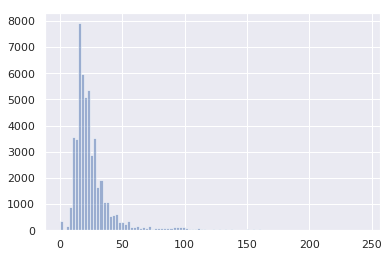

count    51092.000000
mean        65.977531
std         53.938075
min          7.000000
25%         36.000000
50%         51.000000
75%         73.000000
max        476.000000
Name: h, dtype: float64


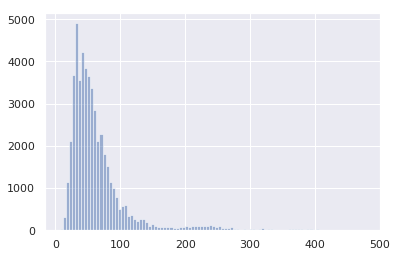

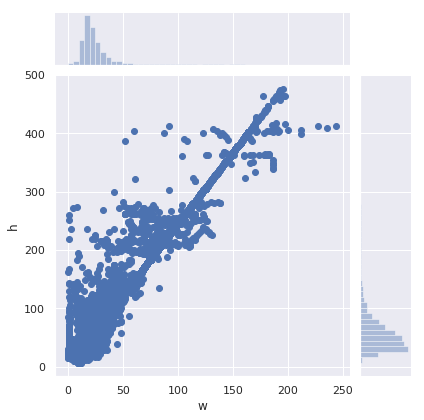

--------------------------------------------------------------------------------


In [23]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2['w'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['w'], bins=100, kde=True, rug=True);
    print(df2['w'].describe())
    plt.show()
    df2['h'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['h'], bins=100, kde=True, rug=True);
    print(df2['h'].describe())
    plt.show()
    sns.jointplot(x="w", y="h", data=df[df['category']==cls]);
    plt.show()
    print(80*'-')

# FPN中anchor的尺寸选取

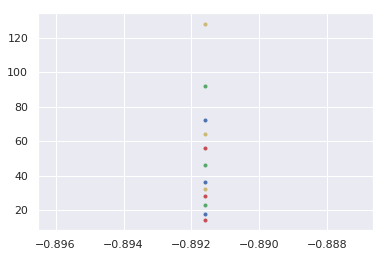

In [24]:
power = np.array([0, 1, 2])
plt.scatter(np.log(np.ones((len(power)))*0.41), 14 * 2. ** power, c='r', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 18 * 2. ** power, c='b', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 23 * 2. ** power, c='g', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 32 * 2. ** power, c='y', marker='.')
plt.show()

/home/tianliang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


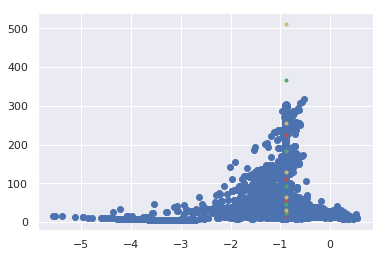

In [25]:
plt.scatter(np.log(df2['w']/df2['h']), np.sqrt(df2['w']*df2['h']))
# plt.scatter(df2['w']/df2['h'], np.sqrt(df2['w']*df2['h']))
power = np.array([0, 1, 2, 3, 4])
plt.scatter(np.log(np.ones((len(power)))*0.41), 14 * 2. ** power, c='r', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 18 * 2. ** power, c='b', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 23 * 2. ** power, c='g', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 32 * 2. ** power, c='y', marker='.')
plt.show()

# anchor的尺寸选取（单层特征，stride=8）

class:  pedestrian
count    51092.000000
mean        41.740034
std         33.748091
min          0.000000
25%         24.372115
50%         31.937439
75%         45.376205
max        317.061508
dtype: float64


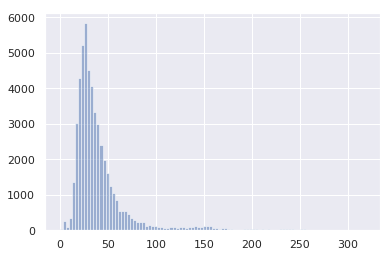

--------------------------------------------------------------------------------


In [26]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = np.sqrt(df2['w']*df2['h'])*1.0  # upsample x1.0
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')


`param_str: "'feat_stride': 8 \n'scales': !!python/tuple [2.0, 2.7, 3.64, 4.92, 6.64, 8.97, 12.11, 16.34, 22.06, 29.79, 40.21]\n'ratios': !!python/tuple [2.44]"`


In [27]:
print(len(df2.sort_values()))
df2_len = len(df2.sort_values())
df2_sort = df2.sort_values()
for i in range(1, 12):
    print("{} {}:  {}".format(i, int(i*df2_len/12), df2_sort[int((i+0.5)*df2_len/12-1):int((i+0.5)*df2_len/12)]))

51092
1 4257:  37207    19.899749
dtype: float64
2 8515:  44017    22.956481
dtype: float64
3 12773:  13620    25.455844
dtype: float64
4 17030:  12419    28.142495
dtype: float64
5 21288:  2185    30.88689
dtype: float64
6 25546:  39023    33.763886
dtype: float64
7 29803:  38635    37.947332
dtype: float64
8 34061:  7022    42.532341
dtype: float64
9 38319:  46997    48.856934
dtype: float64
10 42576:  24687    61.506097
dtype: float64
11 46834:  10534    122.057364
dtype: float64


### upsample x2.0

class:  pedestrian
count    51092.000000
mean        83.480068
std         67.496183
min          0.000000
25%         48.744230
50%         63.874878
75%         90.752410
max        634.123016
dtype: float64


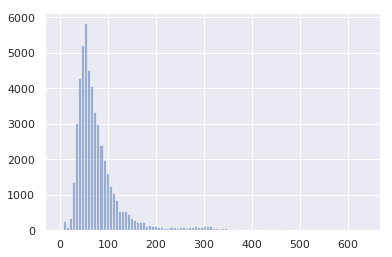

--------------------------------------------------------------------------------


In [28]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = np.sqrt(df2['w']*df2['h'])*2.0  # upsample x1.3
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')


`param_str: "'feat_stride': 8 \n'scales': !!python/tuple [2.0, 2.7, 3.64, 4.92, 6.64, 8.97, 12.11, 16.34, 22.06, 29.79, 40.21]\n'ratios': !!python/tuple [2.44]"`


In [29]:
print(len(df2.sort_values()))
df2_len = len(df2.sort_values())
df2_sort = df2.sort_values()
for i in range(1, 12):
    print("{} {}:  {}".format(i, int(i*df2_len/12), df2_sort[int((i+0.5)*df2_len/12-1):int((i+0.5)*df2_len/12)]))

51092
1 4257:  37207    39.799497
dtype: float64
2 8515:  44017    45.912961
dtype: float64
3 12773:  13620    50.911688
dtype: float64
4 17030:  12419    56.284989
dtype: float64
5 21288:  2185    61.773781
dtype: float64
6 25546:  39023    67.527772
dtype: float64
7 29803:  38635    75.894664
dtype: float64
8 34061:  7022    85.064681
dtype: float64
9 38319:  46997    97.713868
dtype: float64
10 42576:  24687    123.012195
dtype: float64
11 46834:  10534    244.114727
dtype: float64


比较窄的那些框是因为被图片的边缘阶段了，例如下图：

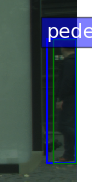

## 宽高比

class:  pedestrian
count    51092.000000
mean         0.422369
std          0.097144
min          0.000000
25%          0.396226
50%          0.404762
75%          0.428571
max          1.714286
Name: aspect, dtype: float64


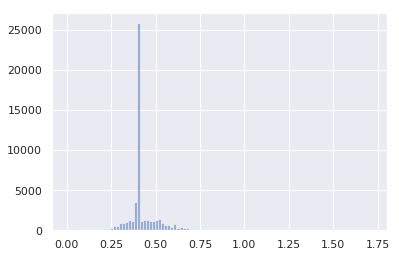

--------------------------------------------------------------------------------


In [30]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['aspect']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

class:  pedestrian
count    51092.000000
mean        41.940409
std         33.815976
min          0.000000
25%         24.372115
50%         32.649655
75%         45.453273
max        317.061508
Name: sqrt_area, dtype: float64


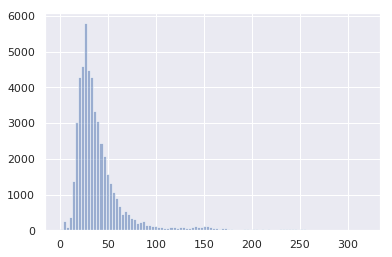

--------------------------------------------------------------------------------


In [31]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['sqrt_area']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

## FPN目标分层分布图

class:  pedestrian
count    51092.000000
mean         2.054275
std          0.256160
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: target_lvls, dtype: float64


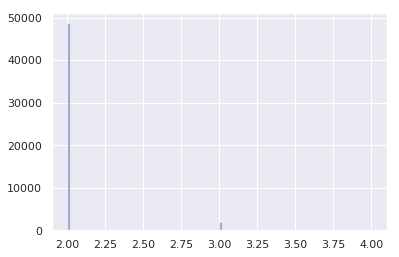

--------------------------------------------------------------------------------


In [32]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['target_lvls']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

In [33]:
df2.value_counts()

2.0    48684
3.0     2043
4.0      365
Name: target_lvls, dtype: int64

## 改进一点点

In [34]:
def map_rois_to_fpn_levels3(areas, k_min=2, k_max=5):
    """Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.
    """
    # Compute level ids
    s = np.sqrt(areas)
    s0 = 112 # default: 224
    lvl0 = 4  # default: 4

    # Eqn.(1) in FPN paper
    target_lvls = np.floor(lvl0 + np.log(s / s0 + 1e-6))
    # target_lvls = np.floor(lvl0 + np.log(s / s0 + 1e-6)/np.log(2))
    target_lvls = np.clip(target_lvls, k_min, k_max)
    return target_lvls

In [35]:
target_lvls3 = []
for area in dic['area']:
    target_lvls3.append(map_rois_to_fpn_levels3(area, k_min=2, k_max=5))

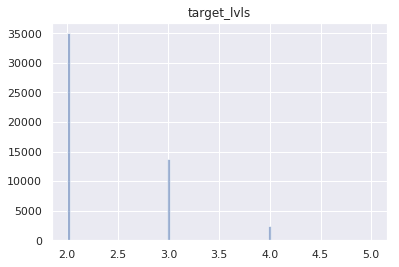

2.0    35006
3.0    13678
4.0     2404
5.0        4
Name: target_lvls, dtype: int64

In [36]:
dic_area3 = dict()
dic_area3['target_lvls'] = target_lvls3
df_target_lvls3 = pd.DataFrame(dic_area3)
df_target_lvls3.hist(color='b', alpha=0.5, bins=100)
plt.show()
df_target_lvls3['target_lvls'].value_counts()

In [37]:
target_lvls = np.sort(target_lvls3)
print(target_lvls)
out = target_lvls - np.hstack((target_lvls[1:], target_lvls[0]))
np.where(out==-1)

[2. 2. 2. ... 5. 5. 5.]


(array([35005, 48683, 51087]),)

## 改进后的特征提取层分配

In [38]:
def map_rois_to_fpn_levels2(areas, k_min=2, k_max=5):
    """Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.
    """
    # Compute level ids
    s = np.sqrt(areas)
    s0 = 112 # default: 224
    lvl0 = 4  # default: 4

    # Eqn.(1) in FPN paper
    target_lvls = np.floor(lvl0 + np.log(s / s0 + 1e-6)/np.log(2))
    target_lvls = np.clip(target_lvls, k_min, k_max)
    return target_lvls

In [39]:
target_lvls2 = []
for area in dic['area']:
    target_lvls2.append(map_rois_to_fpn_levels2(area, k_min=2, k_max=5))

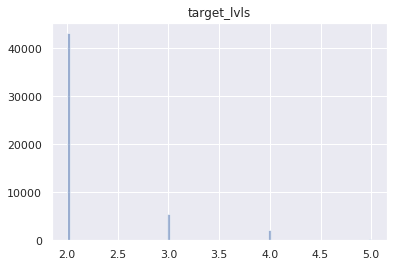

2.0    43123
3.0     5561
4.0     2043
5.0      365
Name: target_lvls, dtype: int64

In [40]:
dic_area = dict()
dic_area['target_lvls'] = target_lvls2
df_target_lvls2 = pd.DataFrame(dic_area)
df_target_lvls2.hist(color='b', alpha=0.5, bins=100)
plt.show()
df_target_lvls2['target_lvls'].value_counts()

In [41]:
target_lvls = np.sort(target_lvls2)
print(target_lvls)
out = target_lvls - np.hstack((target_lvls[1:], target_lvls[0]))
np.where(out==-1)

[2. 2. 2. ... 5. 5. 5.]


(array([43122, 48683, 50726]),)

# 可见部分的框

In [42]:
bboxes = np.empty((len(anns['annotations']), 9))
dic = collections.OrderedDict()
dic['category_num'] = []
dic['category'] = []
dic['x1'] = []
dic['y1'] = []
dic['w'] = []
dic['h'] = []
dic['aspect'] = []
dic['log_aspect'] = []
dic['area'] = []
dic['log_area'] = []
for i in range(len(anns['annotations'])):
    bbox = anns['annotations'][i]['posv']
    dic['category_num'].append(anns['annotations'][i]['category_id'])
    dic['category'].append(id_to_category[str(anns['annotations'][i]['category_id'])])
    dic['x1'].append(bbox[0])
    dic['y1'].append(bbox[1])
    dic['w'].append(bbox[2])
    dic['h'].append(bbox[3])
    dic['aspect'].append(float(bbox[2])/float(bbox[3]))
    dic['log_aspect']= np.log(float(bbox[2])/float(bbox[3]))
    dic['area'].append(anns['annotations'][i]['area'])
    dic['log_area'].append(np.log(anns['annotations'][i]['area']))

df = pd.DataFrame(dic)

print(df.head())

ZeroDivisionError: float division by zero

In [43]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2['w'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['w'], bins=100, kde=True, rug=True);
    print(df2['w'].describe())
    plt.show()
    df2['h'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['h'], bins=100, kde=True, rug=True);
    print(df2['h'].describe())
    plt.show()
    sns.jointplot(x="w", y="h", data=df[df['category']==cls]);
    plt.show()
    print(80*'-')kuangaobi

SyntaxError: invalid syntax (<ipython-input-43-1361c2cd1f8b>, line 16)